In [1]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pandas as pd
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

## Three visits in 2 filters with specified filter pair and time gap


for Fast transients identification

In [2]:
import itertools

In [3]:
from lsst.sims.maf.metrics import BaseMetric


In [32]:

import pylab as pl
def plotregions(filters, opsimdb, dt1=0.5, dt2=1.5):
    filterpairs = []
    ax = pl.figure().add_subplot(111)
    for i in list(itertools.combinations(['g','r','i','z'], 2)):
        #print (''.join(i), filters)
        if not ''.join(i) in filters:
            #print("skip")
            continue
        filterpairs.append(i)
        tmp = pd.read_csv(opsimdb + "/3visits" + ''.join(i) + ".csv", 
            header=None)
        tmp[4] = tmp[4] * 24
        tmp[5] = tmp[5] * 24
        tmp["c1"] = tmp[0].map({'g':1, 'r':2, 'i':3,'z':4})
        tmp["c2"] = tmp[2].map({'g':1, 'r':2, 'i':3,'z':4})
        ax = tmp.plot.scatter(x=4, y=5, alpha=0.2, color=colors[''.join(i)], 
                          ax=ax, label=''.join(i))
        ax.set_xlabel(r"$\Delta t_1$ (hours)", fontsize=15)
        ax.set_ylabel(r"$\Delta t_2$ (hours)", fontsize=15)
    
    ylim = (-2, 4.5)
    xlim = (0, 3.5)
    ax.set_ylim(ylim)
    
    ax.plot([dt1,dt1], [dt2,ylim[1]], 'k')

    ax.plot([xlim[0],  dt1], [dt2,dt2], 'k')
    ax.set_title(opsimdb + " healpix=64, year 1")
    pl.fill_between([xlim[0], 0.5, 0.5, xlim[1]],
                    [ylim[0], ylim[0], ylim[0], ylim[0]],
                    [1.5, 1.5, ylim[1], ylim[1]], color='k', alpha=0.1)

    print(filterpairs)
    pl.savefig("3visits" + "_" + opsimdb + "_" +
               ''.join([''.join(fp) for fp in filterpairs]) + ".png")
    return ((tmp[4] >= dt1) * (tmp[5] <= dt1)).sum() / len(tmp[4]), len(tmp[4])

[('r', 'z')]


/home/docmaf/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(0.024154589371980676, 207)


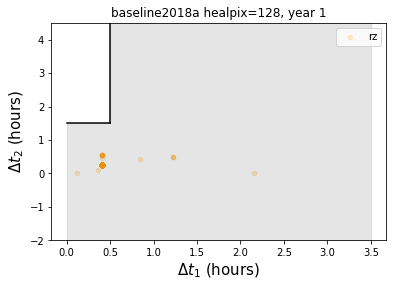

In [29]:
filters = ['rz']
print(plotregions(filters, opsimdb))


In [5]:
class threeVisitsWColorMetric(BaseMetric):
        

    def __init__(self, metricName="threevisits metric ", 
                 filterCol='filter', nightCol='night', 
                 mjdCol='observationStartMJD', dt1=0.5/24, dt2=1.5/24,
                 filters='gi', nVisitsMin=3, **kwargs):
        '''
        Calculates fields for which there are 3 visits in 2 filters with color within dt1 
        and shape at least separated by dt2
        
        returns 1 if the conditionas are all verified for the data slice, -666 otherwise
        default: dt1 30 min dt2 1.5 hours
        default filters y+g (cause there are a few)'''
        
        # Pass the same bins to the plotter.                                                      
        self.metricName = metricName
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol        
        self.nVisitsMin = nVisitsMin
        self.dt1 = dt1
        self.dt2 = dt2
        self.filters = (filters[0], filters[1])
        super(threeVisitsWColorMetric, 
              self).__init__(col=[self.mjdCol, 
                                self.nightCol, 
                                self.filterCol], 
                                metricDtype='int', 
                                units=filters, 
                                **kwargs)

    def run(self, dataSlice, slicePoint=None):
        mins = [99, 99]
        maxs = [-99, -99]
        sorting = np.argsort(dataSlice[self.mjdCol])
        dataSlice = dataSlice[sorting]
        #count the observations within a night for each slice
        n, counts = np.unique(dataSlice[self.nightCol], return_counts=True)
        #print(dataSlice)
        allslices = len(n)
        minobs = n[counts >= 3]
        #print(n, counts, minobs)
        dt1, dt2, filtshape = 100, -1, 'x'

        metricval = 0
        f = open(self.metricName+".csv", "a")
        #iterate over nights with more than 3 observations
        for i,night in enumerate(minobs):
            #this is a night with >=3 observations
            good = dataSlice[self.nightCol] == night
            
            #check if it has 2 filters at least
            n, count = np.unique(dataSlice[self.filterCol][good], 
                                 return_counts=True)
            if len(n) > 1:
                #print(dataSlice[self.filterCol][good])
                #print(n, count)
                #obs with filter 1
                #print (n, count)
                f0 = dataSlice[self.filterCol][good] == self.filters[0]
                #obs with filter 2
                f1 = dataSlice[self.filterCol][good] == self.filters[1]
                
                if f0.sum() == 0 or f1.sum() == 0:
                    metricval = 0.
                    return metricval
                
                if f0.sum() > 1:
                    #max gap with same filter
                    dt2 = dataSlice[self.mjdCol][good][f0][-1] - \
                               dataSlice[self.mjdCol][good][f0][0]
                    #print("dt2", dt2)
                    filtshape = self.filters[0]
                if f1.sum() > 1:
                    #max gap with same filter
                    _tmp = dataSlice[self.mjdCol][good][f1][-1] - \
                               dataSlice[self.mjdCol][good][f1][0]
                    #print("other dt2", _tmp)
                    if  _tmp > dt2:
                            filtshape = self.filters[1]
                            dt2 = _tmp
                dt1 = np.min([np.abs(t1-t2) for t1 in dataSlice[self.mjdCol][good][f0] 
                             for t2 in dataSlice[self.mjdCol][good][f1]])

                f.write("%s,%d,%s,%d,%.3f,%.3f\n"%(
                    self.filters[0], f0.sum(), 
                      self.filters[1], f1.sum(), 
                         dt1, dt2))
                #print (dt1 , "(", self.dt1, ")", dt2, "(", self.dt2, ")", filtshape)
               
            
                #see if obs verify  gap min and max conditions
                if dt1 <= self.dt1 and dt2 >= self.dt2:
                    metricval += 1.0
        f.close()
        #print(metricval)
        return metricval #/ allslices
    
    def reducep(self, metricval):
        result = np.sum(metricval)
        return result


In [36]:

#opsimdb = "pontus_2564"
opsimdb = "pontus_2591"
opsdb = db.OpsimDatabase(opsimdb + '.db')


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint night < 365 for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'night', 'filter']
Found 214393 visits
Running:  [0, 1, 2, 3, 4, 5]


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:456: RuntimeWarning: invalid value encountered in equal
  b.metricValues.mask = np.where(b.metricValues.data == b.metric.badval,


Completed metric generation.
Running reduce methods.
Running summary statistics.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Completed.
Plotting figures with "night < 365" constraint now.
monopole: -8.08797e-06  dipole: lon: 5.42263, lat: -71.5344, amp: 0.00012137


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.000382883  dipole: lon: -109.754, lat: -24.6492, amp: 0.000797453


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: -8.08797e-06  dipole: lon: 5.42263, lat: -71.5344, amp: 0.00012137


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.000315522  dipole: lon: -90.8147, lat: -51.8083, amp: 0.000718685


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


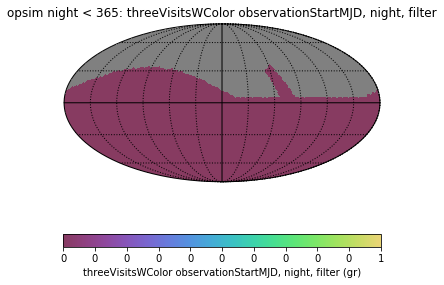

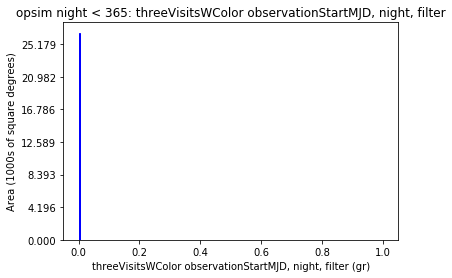

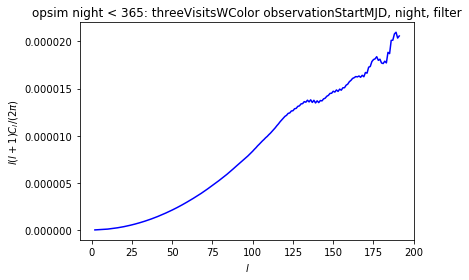

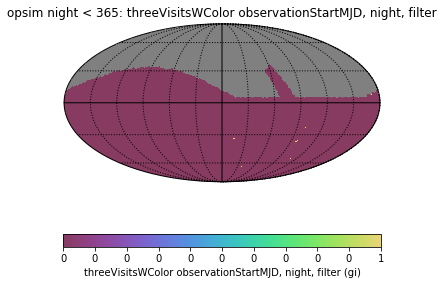

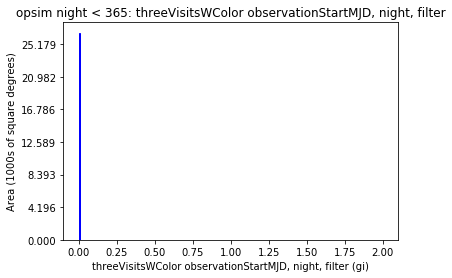

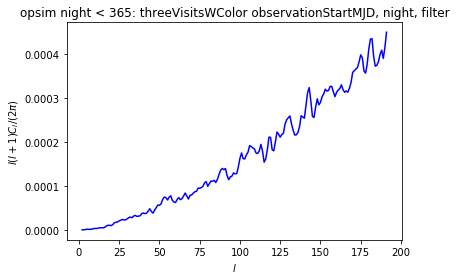

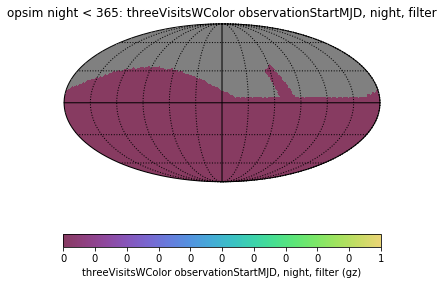

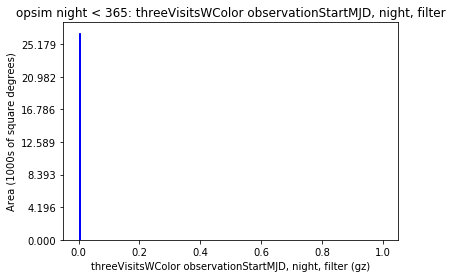

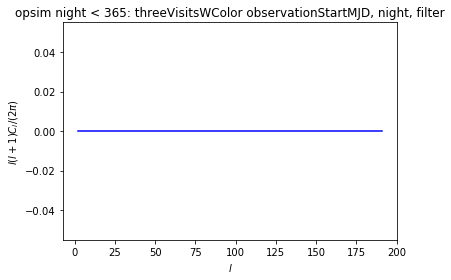

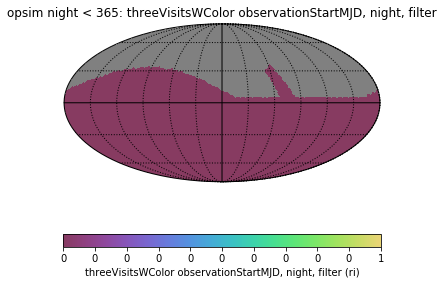

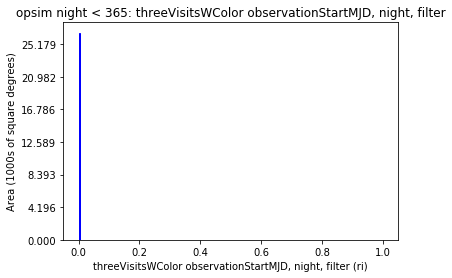

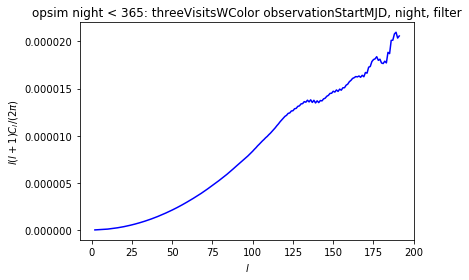

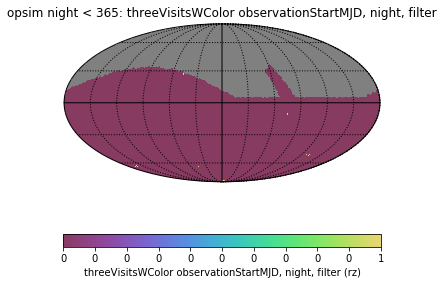

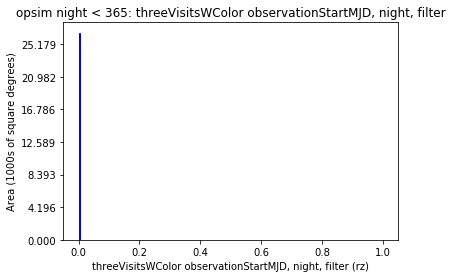

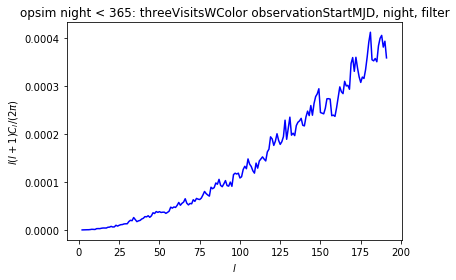

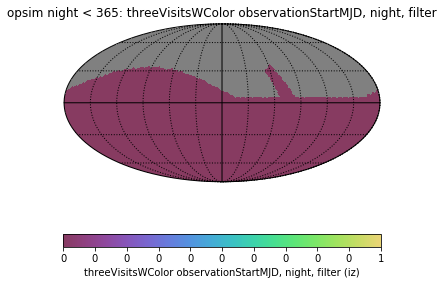

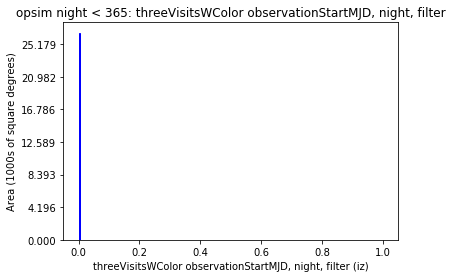

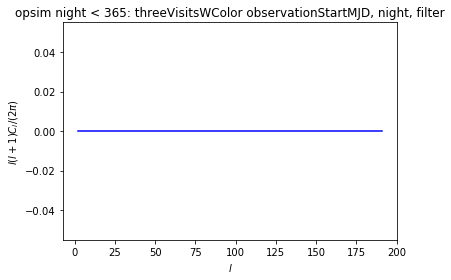

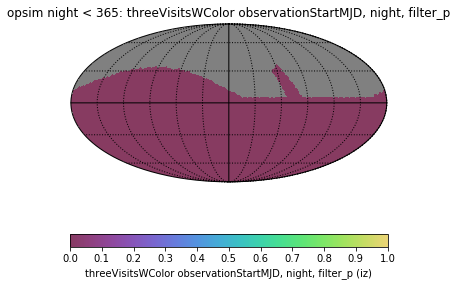

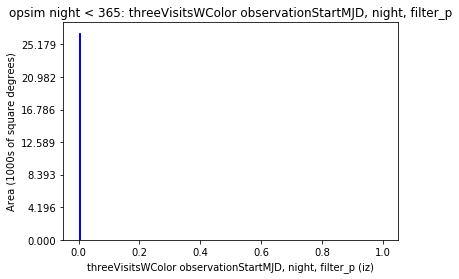

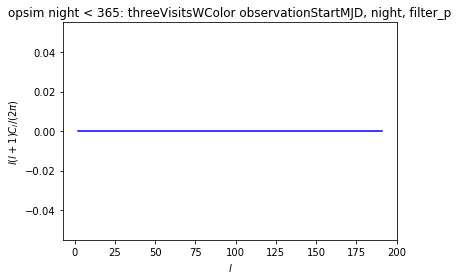

In [37]:
metricList = []
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    pair = ''.join(i)
    metricList.append(threeVisitsWColorMetric(filters=pair, 
                                            metricName="3visits" + pair))
    
slicer = slicers.HealpixSlicer(nside=64)
sqlconstraint = 'night < 365'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint)
    bDict[i].setPlotDict({'colorMin': 0.0, 'colorMax': 1.0})
    
bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir='visitsFastMetric', resultsDb=None)

bgroup.runAll()
bgroup.plotAll(closefigs=False)

[('g', 'i')]


/home/docmaf/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(0.37106918238993708, 12402)
[('r', 'z')]
(0.26958279130273183, 43048)
[('g', 'r'), ('g', 'z'), ('r', 'i'), ('i', 'z')]
(0.063197026022304828, 269)


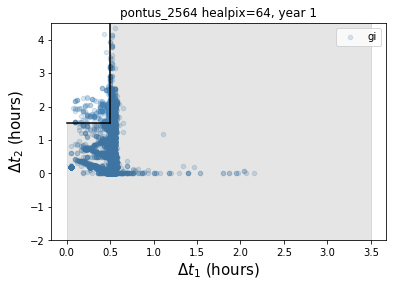

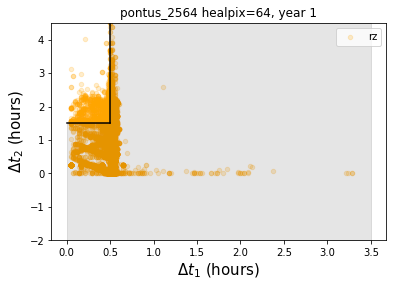

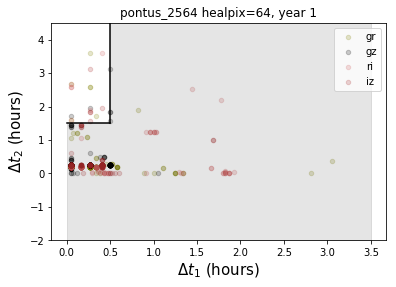

In [33]:
colors = {'gi':'SteelBlue', 'gr':'olive', 'rz':'orange',
          'iz':'brown', 'ri':'IndianRed', 'gz':'k'}

filters = ['rz', 'gi']

opsimdb = "pontus_2591"
#opsimdb = "baseline2018a"

filters = ['gi']
print(plotregions(filters, opsimdb))

filters = ['rz']
print(plotregions(filters, opsimdb))

filters = ['gr','ri','gz', 'iz']
print(plotregions(filters, opsimdb))
#!mv 3visits*.csv pontus_2564

In [34]:
opsimdb = "baseline2018a"
opsdb = db.OpsimDatabase(opsimdb + '.db')


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint night < 365 for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'night', 'filter']
Found 227468 visits
Running:  [0, 1, 2, 3, 4, 5]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


monopole: 0  dipole: lon: 0, lat: nan, amp: 0


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.
mv: target 'opsimdb' is not a directory


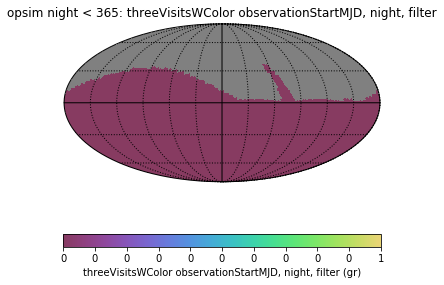

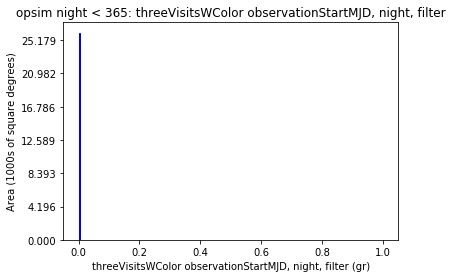

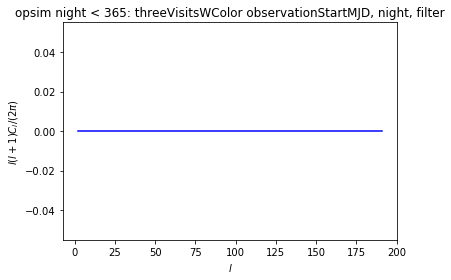

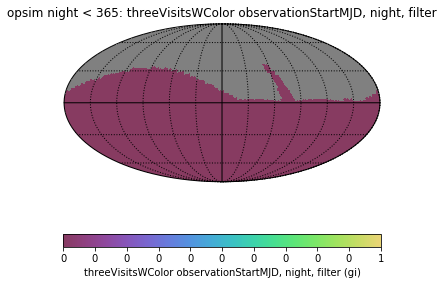

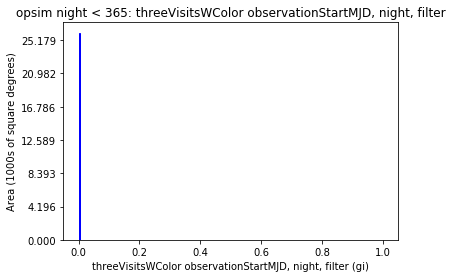

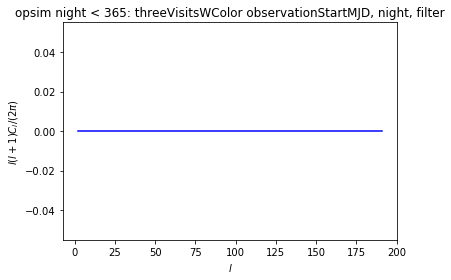

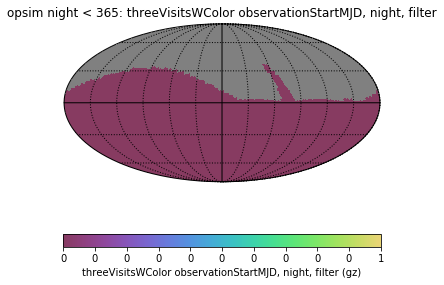

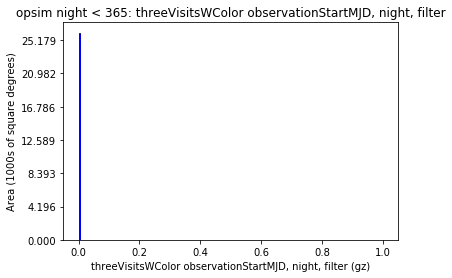

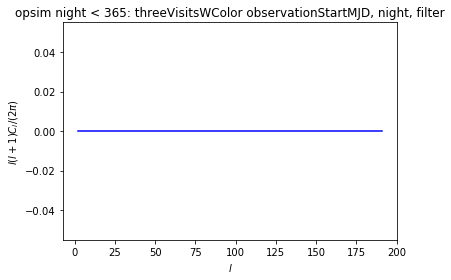

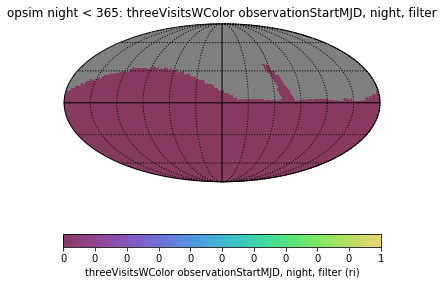

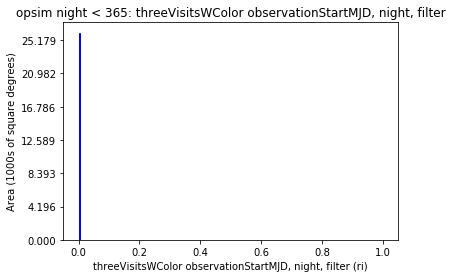

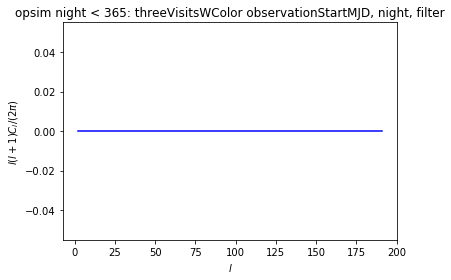

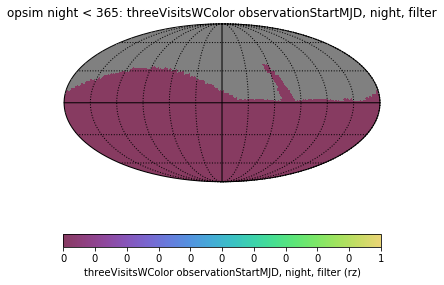

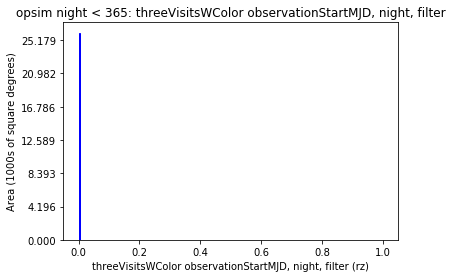

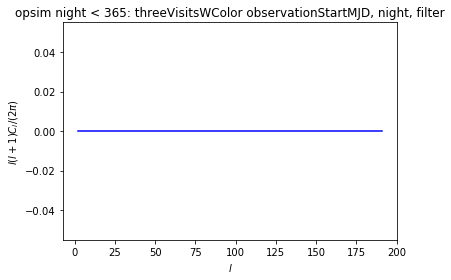

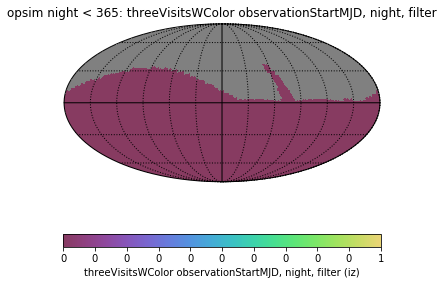

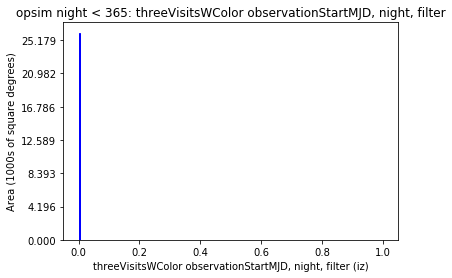

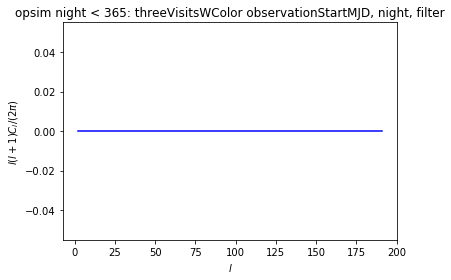

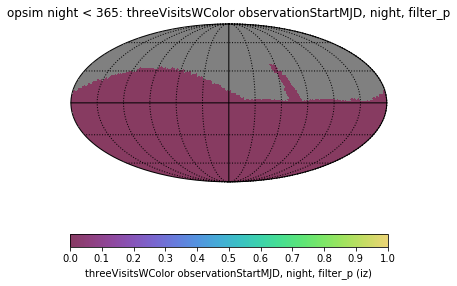

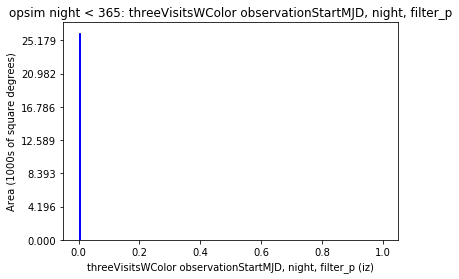

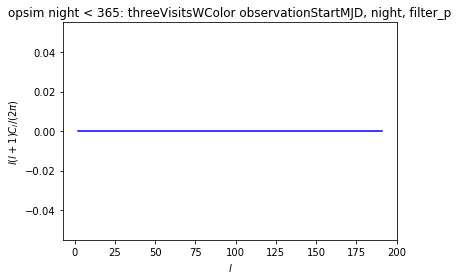

In [13]:
metricList = []
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    pair = ''.join(i)
    metricList.append(threeVisitsWColorMetric(filters=pair, 
                                            metricName="3visits" + pair))
    
slicer = slicers.HealpixSlicer(nside=64)
sqlconstraint = 'night < 365'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint)
    bDict[i].setPlotDict({'colorMin': 0.0, 'colorMax': 1.0})
    
bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir='visitsFastMetric', resultsDb=None)

bgroup.runAll()
bgroup.plotAll(closefigs=False)


[('g', 'i')]


/home/docmaf/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-10a4fa6/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(0.24113475177304963, 282)
[('r', 'z')]
(0.024154589371980676, 207)
[('g', 'r'), ('g', 'z'), ('r', 'i'), ('i', 'z')]
(0.12641083521444696, 443)


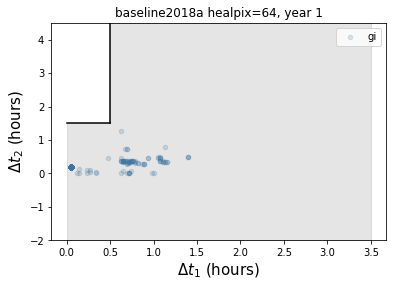

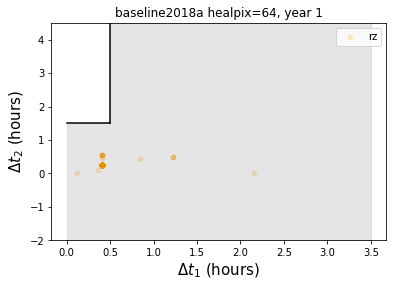

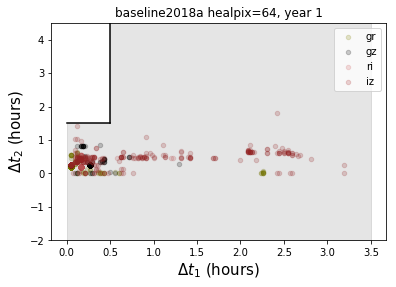

In [35]:
colors = {'gi':'SteelBlue', 'gr':'olive', 'rz':'orange',
          'iz':'brown', 'ri':'IndianRed', 'gz':'k'}

filters = ['rz', 'gi']

opsimdb = "baseline2018a"

filters = ['gi']
print(plotregions(filters, opsimdb))

filters = ['rz']
print(plotregions(filters, opsimdb))

filters = ['gr','ri','gz', 'iz']
print(plotregions(filters, opsimdb))


In [ ]:
colors = {'gi':'SteelBlue', 'gr':'olive', 'rz':'orange', 
          'iz':'brown', 'ri':'IndianRed', 'gz':'k'}

import pylab as pl
ax = pl.figure().add_subplot(111)
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    if ''.join(i) == 'rz' or ''.join(i) == 'gi': continue
    tmp = pd.read_csv("3visits" + ''.join(i) + ".csv", 
            header=None)
    tmp[4] = tmp[4]*24
    tmp[5] = tmp[5]*24
    tmp["c1"] = tmp[0].map({'g':1, 'r':2, 'i':3,'z':4})
    tmp["c2"] = tmp[2].map({'g':1, 'r':2, 'i':3,'z':4})
    ax = tmp.plot.scatter(x=4, y=5, alpha=0.2, color=colors[''.join(i)], 
                          ax=ax, label=''.join(i))
    ax.set_xlabel(r"$\Delta t_1$", fontsize=15)
    ax.set_ylabel(r"$\Delta t_2$", fontsize=15)
    ylim = (-2,5)
    
    ax.set_ylim(ylim)
    ax.plot([0.5,0.5], ylim, 'k')
xlim = ax.get_xlim()
ax.plot(xlim, [1.5,1.5], 'k')
ax.set_title(''.join(i))
pl.fill_between(xlim, [ylim[0], ylim[0]], [1.5,1.5], color='k', alpha=0.1)
pl.fill_between([0.5, xlim[1]], [ylim[1], ylim[1]], [1.5,1.5], color='k', alpha=0.2)
pl.savefig("3visits" + "_" + opsimdb + ".png")

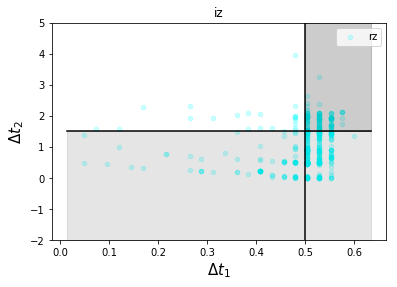

In [16]:
colors = {'gr':'SteelBlue', 'gi':'g', 'ri':'orange', 
          'rz':'cyan', 'iz':'IndianRed', 'gz':'k'}
import pylab as pl
ax = pl.figure().add_subplot(111)
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    if not (''.join(i) == 'rz'):# or ''.join(i) == 'gi'): 
        continue
    tmp = pd.read_csv("3visits" + ''.join(i) + ".csv", 
            header=None)
    tmp[4] = tmp[4]*24
    tmp[5] = tmp[5]*24
    tmp["c1"] = tmp[0].map({'g':1, 'r':2, 'i':3,'z':4})
    tmp["c2"] = tmp[2].map({'g':1, 'r':2, 'i':3,'z':4})
    ax = tmp.plot.scatter(x=4, y=5, alpha=0.2, color=colors[''.join(i)], 
                          ax=ax, label=''.join(i))
    ax.set_xlabel(r"$\Delta t_1$", fontsize=15)
    ax.set_ylabel(r"$\Delta t_2$", fontsize=15)
    ylim = (-2,5)
    
    ax.set_ylim(ylim)
    ax.plot([0.5,0.5], ylim, 'k')
xlim = ax.get_xlim()
ax.plot(xlim, [1.5,1.5], 'k')
ax.set_title(''.join(i))
pl.fill_between(xlim, [ylim[0], ylim[0]], [1.5,1.5], color='k', alpha=0.1)
pl.fill_between([0.5, xlim[1]], [ylim[1], ylim[1]], [1.5,1.5], color='k', alpha=0.2)
pl.savefig("3visits" + "_" + opsimdb + "rz.png")

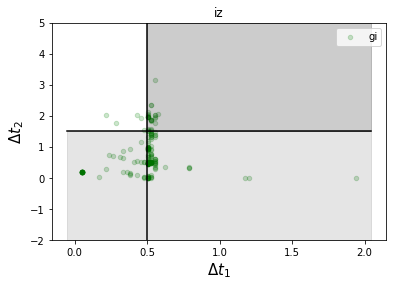

In [17]:
colors = {'gr':'SteelBlue', 'gi':'g', 'ri':'orange', 
          'rz':'cyan', 'iz':'IndianRed', 'gz':'k'}
import pylab as pl
ax = pl.figure().add_subplot(111)
for i in list(itertools.combinations(['g','r','i','z'], 2)):
    if not (''.join(i) == 'gi'):# or ''.join(i) == 'gi'): 
        continue
    tmp = pd.read_csv("3visits" + ''.join(i) + ".csv", 
            header=None)
    tmp[4] = tmp[4]*24
    tmp[5] = tmp[5]*24
    tmp["c1"] = tmp[0].map({'g':1, 'r':2, 'i':3,'z':4})
    tmp["c2"] = tmp[2].map({'g':1, 'r':2, 'i':3,'z':4})
    ax = tmp.plot.scatter(x=4, y=5, alpha=0.2, color=colors[''.join(i)], 
                          ax=ax, label=''.join(i))
    ax.set_xlabel(r"$\Delta t_1$", fontsize=15)
    ax.set_ylabel(r"$\Delta t_2$", fontsize=15)
    ylim = (-2,5)
    
    ax.set_ylim(ylim)
    ax.plot([0.5,0.5], ylim, 'k')
xlim = ax.get_xlim()
ax.plot(xlim, [1.5,1.5], 'k')
ax.set_title(''.join(i))
pl.fill_between(xlim, [ylim[0], ylim[0]], [1.5,1.5], color='k', alpha=0.1)
pl.fill_between([0.5, xlim[1]], [ylim[1], ylim[1]], [1.5,1.5], color='k', alpha=0.2)
pl.savefig("3visits" + "_" + opsimdb + "gi.png")